In [ ]:
%matplotlib inline


# Local Histogram Equalization


This examples enhances an image with low contrast, using a method called *local
histogram equalization*, which spreads out the most frequent intensity values
in an image.

The equalized image [1]_ has a roughly linear cumulative distribution function
for each pixel neighborhood.

The local version [2]_ of the histogram equalization emphasized every local
graylevel variations.

References
----------
.. [1] http://en.wikipedia.org/wiki/Histogram_equalization
.. [2] http://en.wikipedia.org/wiki/Adaptive_histogram_equalization




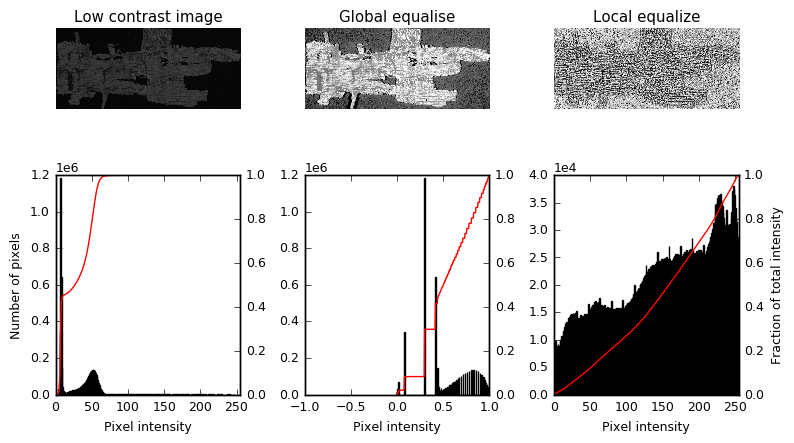

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank


matplotlib.rcParams['font.size'] = 9

def crop(image, ymin, ymax, xmin, xmax):
    return image[ymin:ymax, xmin:xmax]

def thresholded(image, val): 
    return np.logical_and(*[image[...] > val  for t in enumerate([0, 0])])

def find_min_max_without_orphand_pixels(nonzero_dimension, crop_filter=20):
    sorted = np.sort(nonzero_dimension)
    prev=-1
    min_val = sorted[0]
    for i, x in enumerate(sorted[:100]):
        if prev >= 0 and x - prev > crop_filter:
            min_val = x
        prev = x
    prev=-1
    max_val = sorted[-1]
    for i, x in enumerate(sorted[-100:]):
        if prev >= 0 and x - prev > crop_filter:
            max_val = prev
            break
        prev = x
    
    return min_val, max_val


def crop_thresholded(image, crop_val=50):
    temp = crop(image, 600, 4300, 1000, 6000)
    temp = thresholded(temp, crop_val)
    temp = temp * 1
    temp = np.nonzero(temp)
    ymin, ymax = find_min_max_without_orphand_pixels(temp[0])
    xmin,xmax = find_min_max_without_orphand_pixels(temp[1])
    temp = crop(image, 600+ymin, 600+ymax, 1000+xmin, 1000+xmax)
    return temp

def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')

    xmin, xmax = dtype_range[img.dtype.type]
    ax_hist.set_xlim(xmin, xmax)

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = pltimg.imread("/Users/il239838/Downloads/private/Thesis/Papyrus/jm_4a36716c764b6d6b4c442f464b3342347436653838673d3d/P598-Fg009-R/P598-Fg009-R-C01-R01-D07012014-T124136-LR445__001.jpg")
img = crop_thresholded(img)
img = img_as_ubyte(img)

# Global equalize
img_rescale = exposure.equalize_hist(img)

# Equalization
selem = disk(30)
img_eq = rank.equalize(img, selem=selem)


# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1, adjustable='box-forced')
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0],
                         adjustable='box-forced')
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0],
                         adjustable='box-forced')
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')
ax_hist.set_ylabel('Number of pixels')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Global equalise')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Local equalize')
ax_cdf.set_ylabel('Fraction of total intensity')


# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()